# Validation of NISAR Requirement L2-SCI-667:  </br>Ice sheet and glacier velocity measurement - slow deformation
---

This notebook documents and executes the steps need to validate the NISAR slow ice deformation requirement (L2-SCI-667), which is specified as:

**The NISAR Project shall measure ice sheet (> 90% coverage, including both poles) and glaciers and ice-caps (> 80% coverage) horizontal velocity each cold season to an accuracy
 better than the sum of 3% of the horizontal velocity magnitude and 1 m/yr (1-sigma), at 100-m resolution in areas of slow deformation (< 50 m/yr).**
 
As described below this process amounts to comparing L3 velocity products generated as described in the NISAR ATBD with points of known velocity and elevations. Specifically, the Cal/Val points will consist of:
* Zero velocity points on exposed bedrock; and
* On-ice GPS measurements of ice flow speed ($v_x$,$v_y$) and elevation ($z$).

This notebook evaluates the differences between the GPS cal/val points and velocity maps produced by the Greenland Mapping Project sponsored by the NASA MEaSUREs program. The rms values of these differences are used to determine whether the above requirement is met. The S1 data used to derive this projection have a lower resolution than NISAR, hence the products are gridded at 200 rather than 100 m.

Errors are evaluated as the means ($\mu_x,\mu_y$), standard deviations ($\sigma_x,\sigma_y$), and root-mean-squares (rms) of the diferences between the SAR-measured velocity ($v_x,v_y$) and the nominally GPS-measured cal/val points ($u_x,u_y$). Explicitly, these calculations are:

$\bar{\mu}_x = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (v_x-u_x)$, &nbsp;&nbsp;&nbsp;       $\bar{\mu}_y = \frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (v_x-u_x)$ </br>
$\hat{\sigma}_x^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((v_x-u_x)-\bar{\mu_x})^2$, &nbsp;&nbsp;&nbsp;    $\hat{\sigma}_y^2 = \frac{1}{N_{pts}-1}\sum \limits_{i=1}^{N_{pts}} ((v_y-u_y)-\bar{\mu_y})^2$ </br>
$rms_x = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} ((v_x-u_x))^2}$, &nbsp;&nbsp;&nbsp; 
$rms_y = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} ((v_y-u_y))^2}$

The requirement poses the error in terms of a fixed value (1 m/yr) and percentage error (3%). To pass the requirement for a set of points, the mean error of the results should be less than the mean error thresholds for the point. Conceptually, if not rigorously, these two error sources can be thought of as the precision component (1 m/yr) and potential bias (3%). Consistent biases at a point through time can be cause from processing artifacts such as a slope error in the DEM used to apply the surface parallely flow correction. Specifically, the error should be less than:

${thresh}_x = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (1)^2 + (0.03u_x)^2 }$ m/yr, &nbsp;&nbsp;&nbsp;    ${thresh}_y = \sqrt{\frac{1}{N_{pts}}\sum \limits_{i=1}^{N_{pts}} (1)^2 + (0.03u_y)^2 }$ m/yr

Since biases are possible, the requirement is met where the $rms$ for a component is less the than corresponding $thresh$.

The rest of this notebook is designed to access remotely stored L3 velocity maps and evaluate them using a set of GPS cal/val points.

**A present this notebook is only a prototype and works using prodcuts created using data products derived using SAR data from sensors other than NISAR, albeit with the same algorithms and workflow. To emulate the points that will be collected by the project, this notebook uses a recently collected set of GPS points ([Hvidberg et al., 2020](https://tc.copernicus.org/articles/14/3487/2020/)). For purposes of demonstration, it is assumed that any changes in velocity with time are less than the uncertainty in the individual measurements.**

## Python Setup

In [5]:
from IPython.lib.deepreload import reload
%load_ext autoreload
%autoreload 2
import nisardev as nisar
import os
from urllib import request
import gimpfunc as gimp
import matplotlib.pyplot as plt
import panel
import numpy as np
from datetime import datetime
import pandas as pd
panel.extension()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Login for Remote Access

For remote access to data at NSIDC, run these cells to login with a valid NASA EarthData Login (see  [NSIDCLoginNotebook](https://github.com/fastice/GIMPNotebooks/blob/master/NSIDCLoginNotebook.ipynb) for further details and security concerns). Descriptions of these data products are avaiable at [NSIDC](https://nsidc.org/data/measures/gimp). The algorithms used to produce these products are described in the written ATBD and the [NISAR Users handbook](https://nisar.jpl.nasa.gov/rails/active_storage/disk/eyJfcmFpbHMiOnsibWVzc2FnZSI6IkJBaDdDRG9JYTJWNVNTSXBZV0V4T1RRNE5HVXRaV1V6WVMwMFltTXpMV0ppWkdRdE16VXpNekZoWldNeFkyWTFCam9HUlZRNkVHUnBjM0J2YzJsMGFXOXVTU0pYYVc1c2FXNWxPeUJtYVd4bGJtRnRaVDBpVGtsVFFWSmZSa2xPUVV4Zk9TMDJMVEU1TG5Ca1ppSTdJR1pwYkdWdVlXMWxLajFWVkVZdE9DY25Ua2xUUVZKZlJrbE9RVXhmT1MwMkxURTVMbkJrWmdZN0JsUTZFV052Ym5SbGJuUmZkSGx3WlVraUZHRndjR3hwWTJGMGFXOXVMM0JrWmdZN0JsUT0iLCJleHAiOiIyMDIyLTAxLTI3VDIxOjA2OjEzLjk0OFoiLCJwdXIiOiJibG9iX2tleSJ9fQ==--46c90ad132272eb5855fecb3070780e162777a62/NISAR_FINAL_9-6-19.pdf?content_type=application%2Fpdf&disposition=inline%3B+filename%3D%22NISAR_FINAL_9-6-19.pdf%22%3B+filename%2A%3DUTF-8%27%27NISAR_FINAL_9-6-19.pdf).

In [6]:
env = dict(GDAL_HTTP_COOKIEFILE=os.path.expanduser('~/.gimp_download_cookiejar.txt'),
            GDAL_HTTP_COOKIEJAR=os.path.expanduser('~/.gimp_download_cookiejar.txt'))
os.environ.update(env)

In [7]:
myLogin = gimp.NASALogin()  # If login appears not to work, try rerunning this cell
myLogin.view()

Already logged in. Proceed.


# Cal/Val Points (cvPoints)

The **cvPoints** class is used to read in, filter (by speed), and interpolate cal/val points. 

At present, cal/val points are stored in a flat ascii file with rows given by:

*lat lon elevation vx vy vz 
...*
The following examples demontrate selection of point locations by speed.

In [8]:
myCVPts = nisar.cvPoints(cvFile='GPSpoints/NEGIS-GPS.txt') # Read points for the Northeast Greenland Ice Stream
x, y = myCVPts.xyAll() # Returns all cal/val points
x0, y0 = myCVPts.xyZero() # Returns stationary (v=0) points
x50, y50 = myCVPts.xyVRange(0, 30) # Returns all cal/val points with speeds between 0 and 30 m/yr

The bounding box of the cal/val points with a 20-km pad can be found as:

In [9]:
cvBounds = myCVPts.boundingBox(pad=20e3, units='m') # Get the bounding box for the cal/val points with a 10km pad.
print(cvBounds)

{'minx': 191200.0, 'miny': -1574000.0, 'maxx': 282800.0, 'maxy': -1503100.0}


This box is used below to limit the extent of the remote velocity maps for faster remote access and display.

## Select Data

By default, running this cell will select the 6 annual velocity maps archived at NSIDC, which are representative of the products for the slow-deformation ice sheet requirement. The controls in this cell can use used to a select a varient of other velocity maps, at 6-to-12 day, monthly, quarterly, and annual resolution.

In [10]:
myUrls = gimp.cmrUrls(mode='nisar')  # Subsetter mode is required for subsetting.
myUrls.initialSearch()

Row
    [0] Column(min_width=400)
        [0] Markdown(str)
        [1] Param(cmrUrls, name='Select Product &..., widgets={'product': <class 'panel....}, width=400)
        [2] Row
            [0] Markdown(str)
            [1] Markdown(str)
    [1] Column
        [0] ParamMethod(method)
        [1] ParamMethod(method)
        [2] ParamMethod(method)

## Initialize Data and Subset Data

Each component in the velocity maps is ~240MB, so downloading 6 maps with 2 components each (~3GB) can take a few minutes. To avoid this wait, the urls returned from the search and crop them to match the  bounding box for the cal/val points as shown below. Before reading setting up the velocity, the url names are modifed to insert a wildcard ('\*') for the velocity components and remote the '.tif' extension.

In [11]:
myCogs = [x.replace('vv', '*').replace('.tif','') for x in myUrls.getCogs()]
myVelSeries = nisar.nisarVelSeries()
myVelSeries.readSeriesFromTiff(myCogs, url=True, readSpeed=False)
myVelSeries.subSetVel(cvBounds) # Apply subset
myVelSeries.loadRemote() # Load the data to memory

[########################################] | 100% Completed | 14.7s


### Velocity and Point Locations

The locations of the cal/val points, including those with speeds < 50 m/yr, are plotted over the velocity maps for each year as:

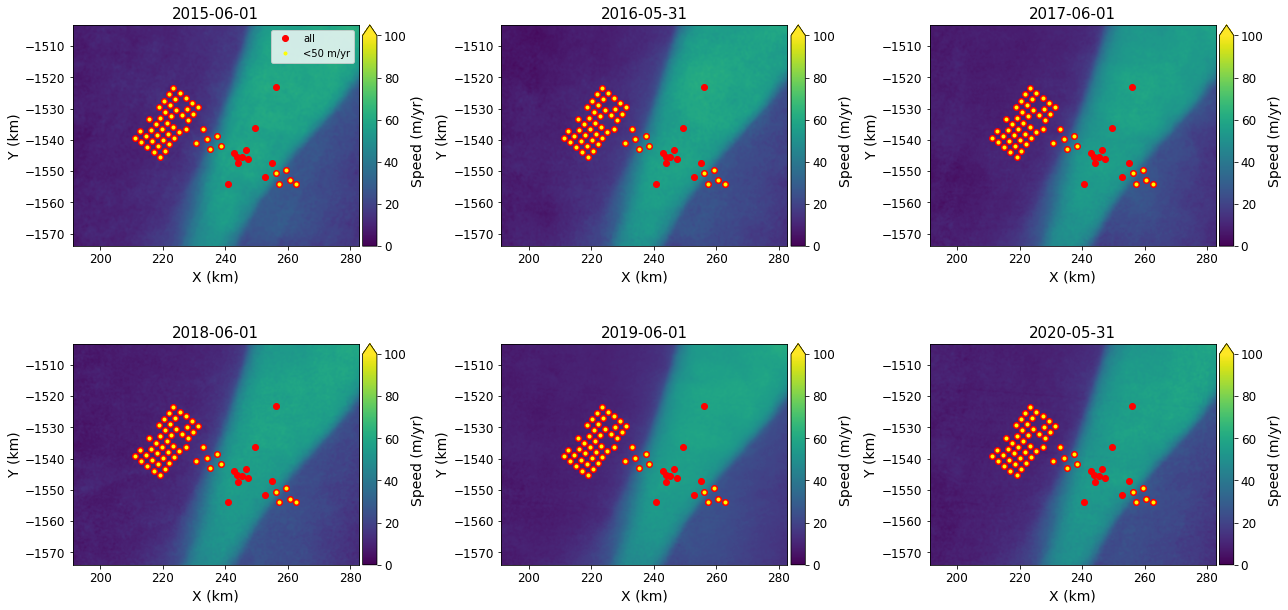

In [12]:
fig, axes = plt.subplots(2, np.ceil(myVelSeries.nLayers/2).astype(int), figsize=(18, 9))
for ax, date in zip(axes.flatten(), myVelSeries.time):  # Loop and display map for each time
    myVelSeries.displayVelForDate(date, ax=ax, units='km')
    myCVPts.plotAllCVLocs(ax=ax, color='red', marker='o', label='all', units='km')  # Show all points
    myCVPts.plotVRangeCVLocs(0, 50, ax=ax, color='yellow', label='<50 m/yr', date=date, units='km') # Over plot slow points
    #ax.axis('off')
axes[0][0].legend();
fig.tight_layout()

### Cal/Val and Estimated Velocity Differences

The differences between the estimated velocity ($v_x$ and $v_y$) and the cal/val measurements ($u_x$ and $u_y$) for each year are displayed as:

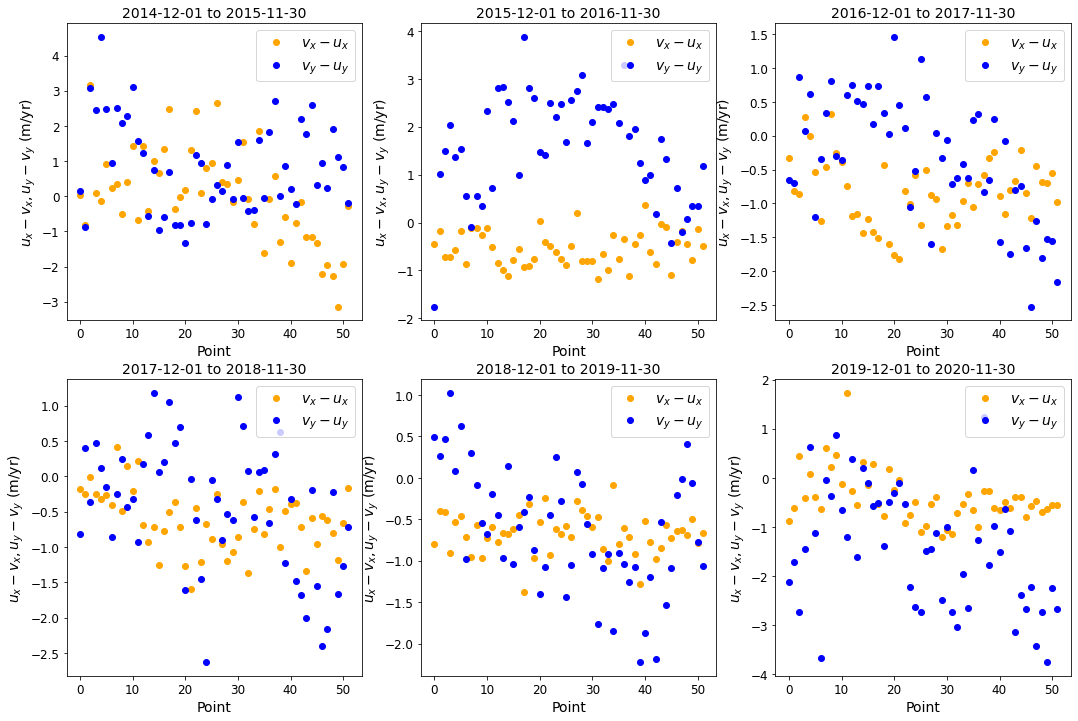

In [13]:
fig, axes = plt.subplots(2,3, figsize=(18,12))
for ax, date, date1, date2 in zip(axes.flatten(), myVelSeries.time, myVelSeries.time1, myVelSeries.time2):
    # Plot the differences for GPS points with v < 50
    myCVPts.plotVRangeCVDiffs(myVelSeries, 0, 50, ax=ax, date=date, xColor='orange', marker='o', 
                              legendKwargs={'loc': 'upper right', 'fontsize': 14})
    ax.set_title(f'{date1.strftime("%Y-%m-%d")} to {date2.strftime("%Y-%m-%d")}', fontsize=14)

## Summary

The table below summarizes the statistics for the differences between the observed (SAR) and measured (GPS) velocities. Cases where the requiresments are not met are flagged with red text.

In [14]:
tables = []
# return result for each product as one-row pandas data frame
thresholds = []
for date in myVelSeries.time:
    # Compute each velocity map
    result = myCVPts.vRangeStats(myVelSeries, 0, 50, date=date, table=True)
    tables.append(result[-1])
df = pd.concat(tables, axis=0) # Concatenate individual results to single dataframe
caption = f'Of {len(df["RMS"]) * 2} components derived from {len(df["RMS"])} estimates, {np.sum(df["RMS"][df["RMS"] > 1].count())} do not meet requirements.'
df.style.pipe(myCVPts.statsStyle, **{'caption': caption})
